# Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# package imports

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.metrics import classification_report, confusion_matrix

from ast import literal_eval

import time
import datetime


import json

from random import sample
from random import seed

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
import os
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import matplotlib.image as mpimg
import matplotlib.cm as cm

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers as reg

from keras.callbacks import ModelCheckpoint

from sklearn.utils import resample

In [ ]:
#This cell uploads the data from the drive where we placed the dataset

base_path = "/content/drive/MyDrive/DL Project/Covid/data_upload_v3/"

# train
train_nocovid_path = "train/non/"
entries_train_nocovid = os.listdir(base_path + train_nocovid_path)
entries_train_nocovid = [train_nocovid_path + entry for entry in entries_train_nocovid]
print(entries_train_nocovid[0])
train_covid_path = "train/covid/"
entries_train_covid = os.listdir(base_path + train_covid_path)
entries_train_covid = [train_covid_path + entry for entry in entries_train_covid]
print(entries_train_covid[0])

#test
test_nocovid_path = "test/non_all/"
entries_test_nocovid = os.listdir(base_path + test_nocovid_path)
entries_test_nocovid = [test_nocovid_path + entry for entry in entries_test_nocovid]
print(entries_test_nocovid[0])
test_covid_path = "test/covid/"
entries_test_covid = os.listdir(base_path + test_covid_path)
entries_test_covid = [test_covid_path + entry for entry in entries_test_covid]
print(entries_test_covid[0])

# Size of dataset
print("Train no covid: " + str(len(entries_train_nocovid)))
print("Train covid: " + str(len(entries_train_covid)))
print("Test no covid: " + str(len(entries_test_nocovid)))
print("Test covid: " + str(len(entries_test_covid)))

train/non/No Finding-patient12754-study1-view1_frontal.jpg
train/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg
test/non_all/patient05879-study2-view1_frontal.jpg
test/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png
Train no covid: 2000
Train covid: 84
Test no covid: 3000
Test covid: 100


In [ ]:
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


#The following functions are used to construct rapidly a new model in a flexible and fast way


# Define the model
def build_model(optimizer = 'adam'):
    classifier = Sequential()
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
    return classifier

#Add convolutional layers with max pooling. Use a list of filters numbers, 
# if all layers have same number of filters just set an integer  and specify n 
def add_cnl(classifier, neurons, kernel_size = (3, 3), p_size = (2,2), n = 0, drop = 0):
    if n == 0:
        classifier.add(Conv2D(neurons[0], kernel_size, input_shape = (150, 150, 1), activation = 'relu'))
        classifier.add(MaxPooling2D(pool_size = p_size))
        for i in range(1, len(neurons)):
            classifier.add(Conv2D(neurons[i], kernel_size, activation = 'relu'))
            classifier.add(MaxPooling2D(pool_size = p_size))
            
    else:
        classifier.add(Conv2D(neurons, kernel_size, input_shape = (150, 150, 1), activation = 'relu'))
        for i in range(1, n):
            classifier.add(Conv2D(neurons, kernel_size, activation = 'relu'))
            classifier.add(MaxPooling2D(pool_size = p_size))

    classifier.add(Flatten())
        
    if drop != 0:
        classifier.add(Dropout(drop))
#similar structure with average pooling

def add_cnl2(classifier, neurons, kernel_size = (3, 3), p_size = (2,2), n = 0, drop = 0):
    if n == 0:
        classifier.add(Conv2D(neurons[0], kernel_size, input_shape = (150, 150, 1), activation = 'relu'))
        classifier.add(AveragePooling2D(pool_size = p_size))
        for i in range(1, len(neurons)):
            classifier.add(Conv2D(neurons[i], kernel_size, activation = 'relu'))
            classifier.add(AveragePooling2D(pool_size = p_size))
            
    else:
        classifier.add(Conv2D(neurons, kernel_size, input_shape = (150, 150, 1), activation = 'relu'))
        for i in range(1, n):
            classifier.add(Conv2D(neurons, kernel_size, activation = 'relu'))
            classifier.add(AveragePooling2D(pool_size = p_size))

    classifier.add(Flatten())
        
    if drop != 0:
        classifier.add(Dropout(drop))
# Add the dense hidden layers + the output unit
def add_dense(classifier, neurons, n = 0, end = True, reg = None):
    if n == 0:
        for neu in neurons:
            classifier.add(Dense(neu,kernel_regularizer = reg, activation = 'relu'))

    else:
        for i in range(n):
            classifier.add(Dense(neurons,kernel_regularizer = reg ,activation = 'relu'))
    
    if end:
        classifier.add(Dense(units = 1, activation = 'sigmoid'))

#Oversampling
#This function is used to oversample the Covid data in the training process

def oversampling(traindf):
    covid_df_upsampled = resample(traindf.loc[traindf["class"]=="1"],
                          replace=True, # sample with replacement
                          n_samples=len(traindf.loc[traindf["class"]=="0"]), # match number in majority class
                          random_state=23) # reproducible results
    upsampled= pd.concat([covid_df_upsampled, traindf.loc[traindf["class"]=="0"]])
    return upsampled

def macro_double_soft_f1(y, y_hat):
    """
    From: https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
    Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [ ]:
# plotting functions to visualize the histories


def plot_metrics(history, metrics = ['loss',  "accuracy" ,'auc', 'precision', 'recall',"f1"]):
  
  if "f1" in metrics:
    precision = history["precision"]
    recall = history["recall"]
    precision_val = history["val_precision"]
    recall_val = history["val_recall"]
    f1 = []
    f1_val = []
    for i in range(len(precision)):
      if (precision[i]+recall[i]) == 0:
        f1_single = 0
      else:
        f1_single = (2*precision[i]*recall[i])/(precision[i]+recall[i])
      if (precision_val[i]+recall_val[i]) == 0:
        f1_val_single = 0
      else:
        f1_val_single = (2*precision_val[i]*recall_val[i])/(precision_val[i]+recall_val[i])
      f1.append(f1_single)
      f1_val.append(f1_val_single)
    history["f1"] = f1
    history["val_f1"] = f1_val
  plt.figure(figsize=(15,15))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(range(len(history[metric])), history[metric], label='Train')
    plt.plot(range(len(history[metric])), history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()
  plt.show(block=False)

In [ ]:
X_train_paths = entries_train_nocovid + entries_train_covid
# merging array of 0's for each no covid image and array of 1's for each covid image
y_train_labels = [ 0 for i in range(len(entries_train_nocovid))] + [ 1 for i in range(len(entries_train_covid))]

X_test_paths = entries_test_nocovid + entries_test_covid
# merging array of 0's for each no covid image and array of 1's for each covid image
y_test_labels = [ 0 for i in range(len(entries_test_nocovid))] + [ 1 for i in range(len(entries_test_covid))]

# Visualization of Image Augmentation

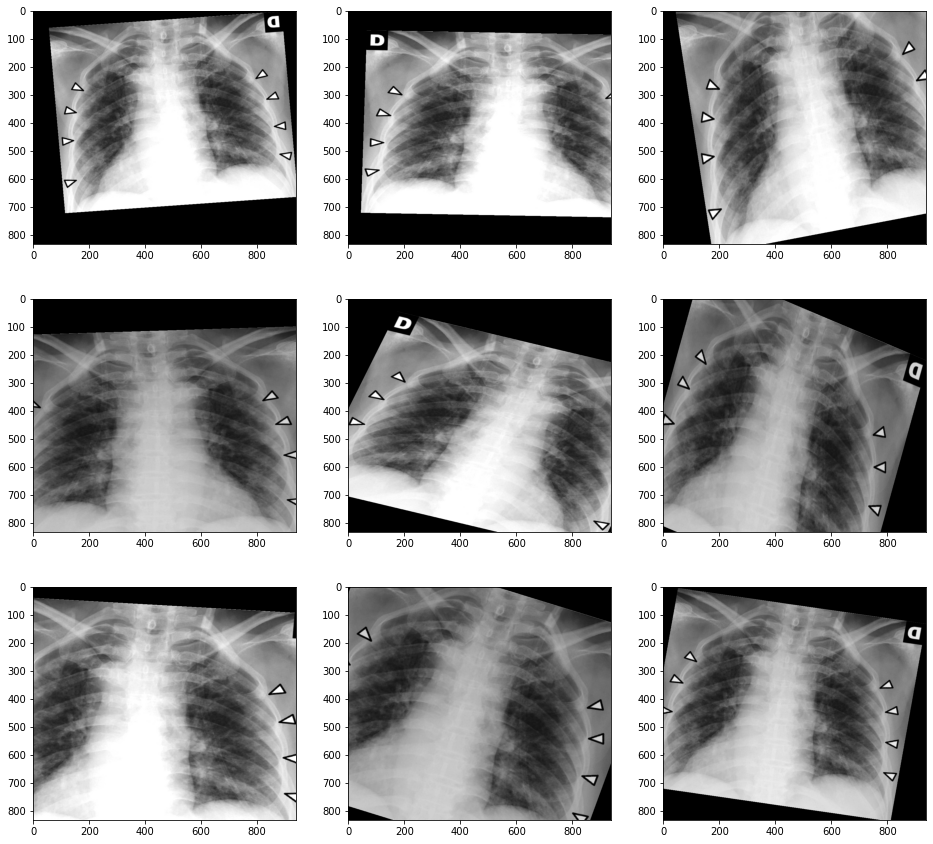

In [ ]:
#Visualization of Image Augmentation

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 20,
                              width_shift_range=0.1,
                              height_shift_range = 0.1,
                              zoom_range=[0.8, 1.3],
                              brightness_range=[0.8,1.2],
                              horizontal_flip=True,
                              fill_mode = "constant")


# load the image
chosen_image = base_path + X_train_paths[2082]
img = load_img(chosen_image)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

# prepare iterator
it = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(16,15))
for i in range(9):
    #define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    image = batch[0]
    plt.imshow(image)
plt.show()

# Try different architectures

In [ ]:
# In the following cells an example of our procedure for the evaluation of different architectures
# The training and validation of all the other models besides the final are spread across different notebooks and therefore not submitted.
model_number = 
k = 10
number_of_its = 10
epochs = 30
#decide which class weights to use
class_weight = {0: , 1: }
#keeping fixed the random state of the split should guarantee comparison between different architectures
#more consistent
kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)
X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []

In [ ]:
# Build the directories where will be saved the histories
if not os.path.exists("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)):
    os.makedirs("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number))

#Build a list of callbacks
directories = ["/content/drive/MyDrive/DL Project/Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

In [ ]:
# K-fold training
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    #oversample the covid data
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)
    #define the model you want to try
    model = build_model()
    add_cnl2(model,neurons = , drop = )
    add_dense(model, neurons =  , n = , reg =  )

    #train
    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]], class_weight=class_weight)
    histories.append(history.history)
    json.dump(histories[i], open("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

    # EVALUATION ON LAST EPOCH
    #(the actual evaluation comes later with callbacks)

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

In [ ]:
best = []
for j in range(k):
    # find the best f1 score for j-th fold
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    #np.argmax considers the first occurrence
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
#choose median epoch as validation
val_epoch = sorted(best)[len(best)//2]+1 #(+1 since python starts indexing from 0 while epoch counts start from 1)
print("VALIDATION EPOCH: "+str(val_epoch))

In [ ]:
val_y_true_list = []
val_y_predictions_list = []
#Recall the validation indexes using same Kfold split as before
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  #load the weights of fold i at validation epoch
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch)+".hdf5")

  #prediction on validation data
  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

In [ ]:
#Plot histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])

#Print overall evaluation at validation epoch
print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

# Final Model 2.8

In [ ]:
model_number = 28
k = 10
number_of_its = 10
epochs = 30
class_weight = {0: 0.5, 1: 2}
kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []

if not os.path.exists("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)):
    os.makedirs("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number))

directories = ["/content/drive/MyDrive/DL Project/Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl2(model,neurons = [32, 64, 128], drop = 0.4)
    add_dense(model, neurons = 128, n = 2, reg = reg.l2(0.005) )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]], class_weight=class_weight)
    histories.append(history.history)
    json.dump(histories[i], open("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 47s 1s/step - loss: 1.9053 - accuracy: 0.4355 - precision: 0.4317 - recall: 0.9960 - auc: 0.6476 - val_loss: 2.4054 - val_accuracy: 0.0431 - val_precision: 0.0431 - val_recall: 1.0000 - val_auc: 0.8153
Epoch 2/30
24/24 [==============================] - 51s 1s/step - loss: 0.9859 - accuracy: 0.5717 - precision: 0.5402 - recall: 0.9938 - auc: 0.8213 - val_loss: 0.7288 - val_accuracy: 0.8995 - val_precision: 0.2000 - val_recall: 0.4444 - val_auc: 0.8506
Epoch 3/30
24/24 [==============================] - 54s 1s/step - loss: 0.7084 - accuracy: 0.7923 - precision: 0.7280 - recall: 0.9459 - auc: 0.9050 - val_loss: 1.3446 - val_accuracy: 0.4545 - val_precision: 0.0732 - val_recall: 1.0000 - val_auc: 0.9233
Epoch 4/30
24/24 [==============================] - 54s 1s/step - loss: 0.59

FOLD: 0best epoch: 6F1 score: 0.9411764743006353
FOLD: 1best epoch: 7F1 score: 1.0
FOLD: 2best epoch: 12F1 score: 1.0
FOLD: 3best epoch: 4F1 score: 1.0
FOLD: 4best epoch: 10F1 score: 1.0
FOLD: 5best epoch: 8F1 score: 1.0
FOLD: 6best epoch: 16F1 score: 1.0
FOLD: 7best epoch: 6F1 score: 1.0
FOLD: 8best epoch: 8F1 score: 1.0
FOLD: 9best epoch: 10F1 score: 1.0
VALIDATION EPOCH: 8
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.

Iteration 0


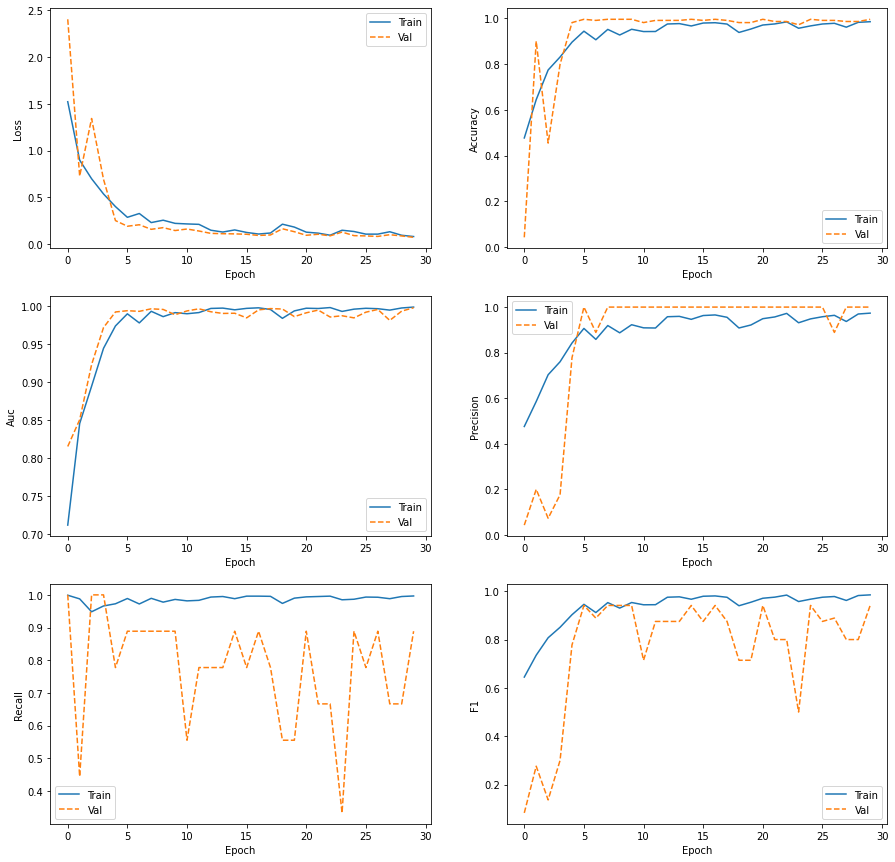

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 1


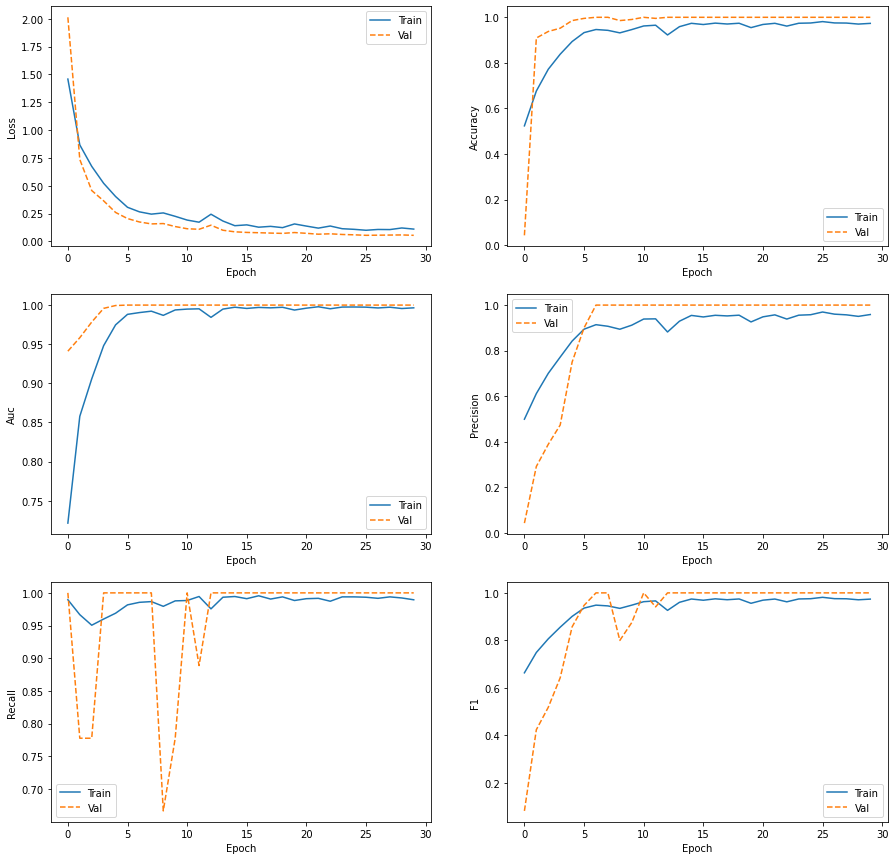

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         9

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209


Iteration 2


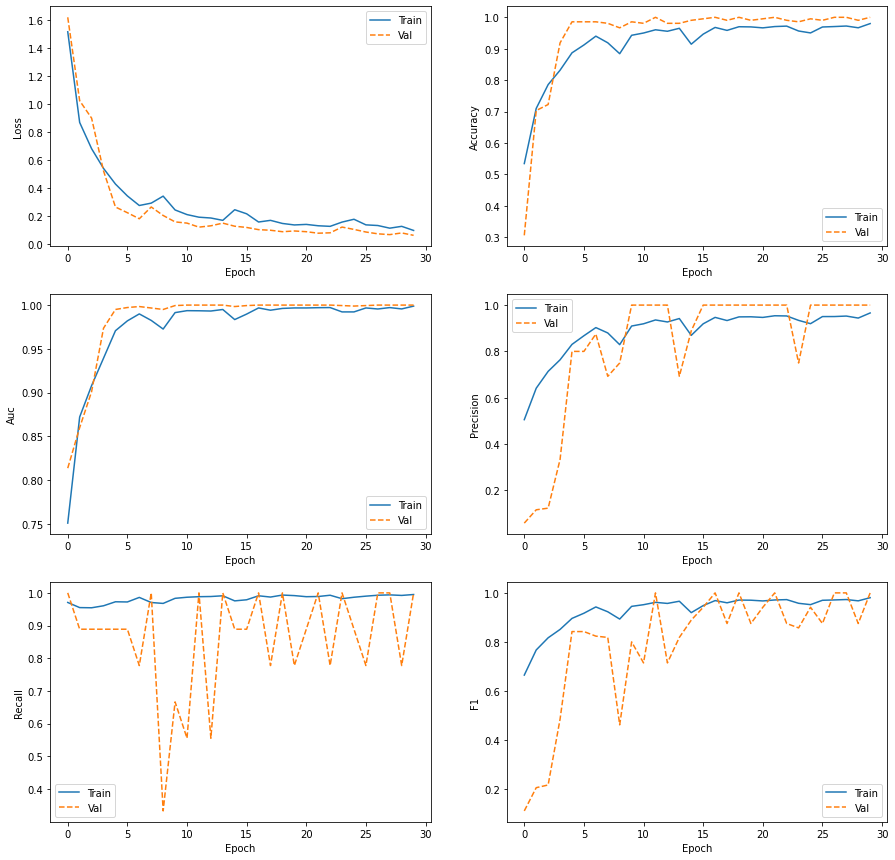

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         9

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209


Iteration 3


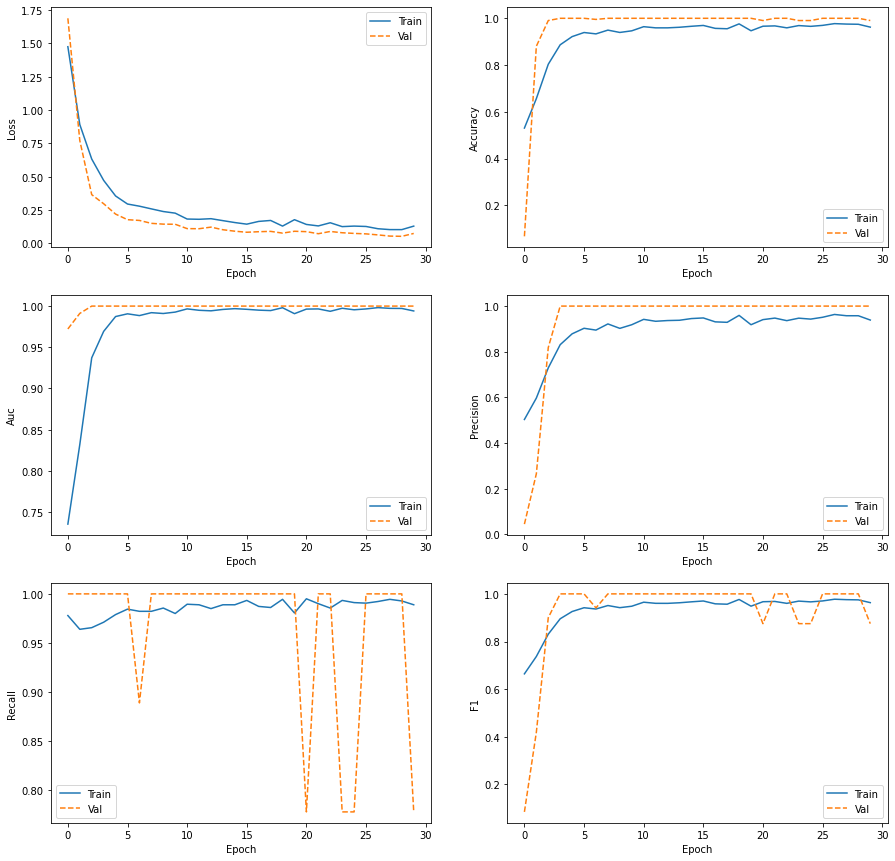

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 4


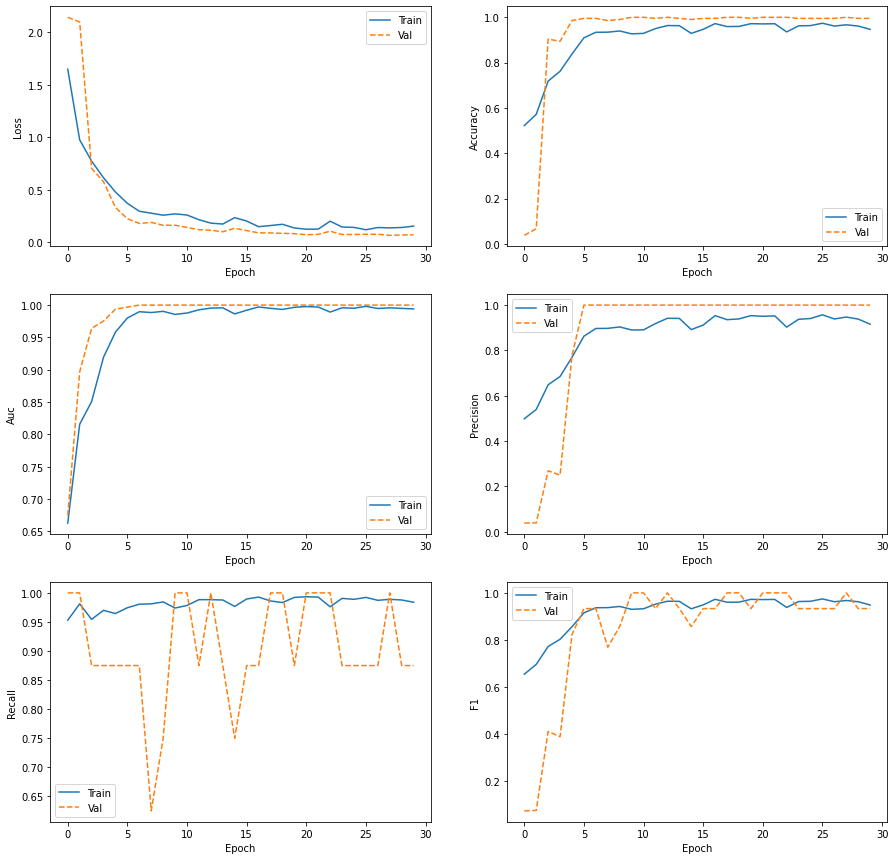

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 5


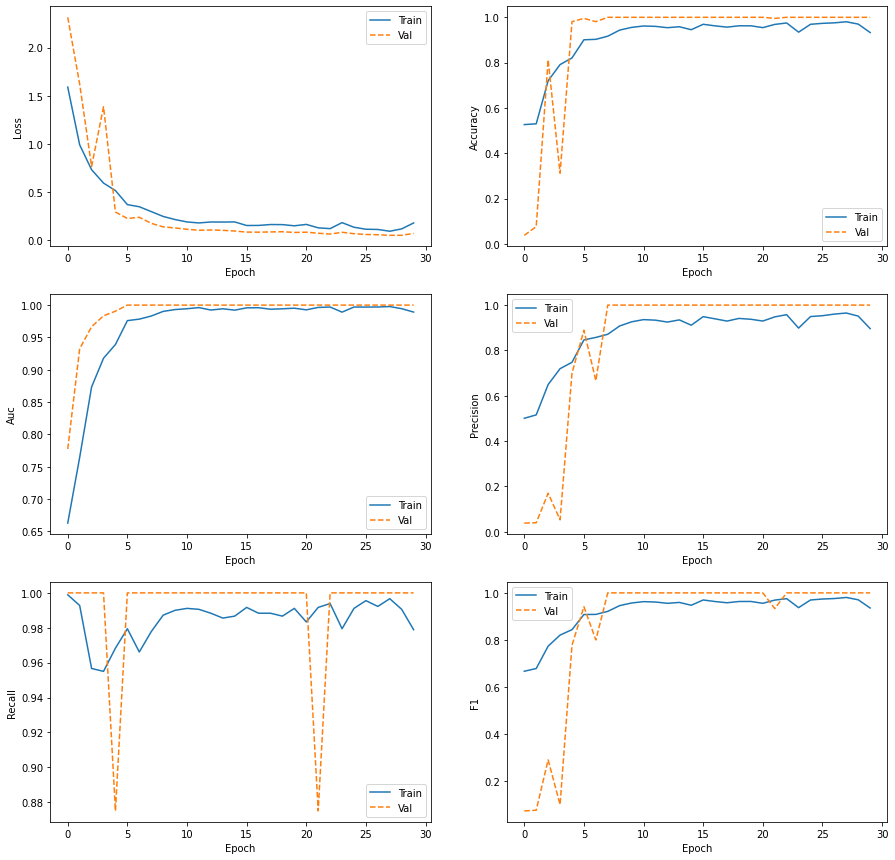

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 6


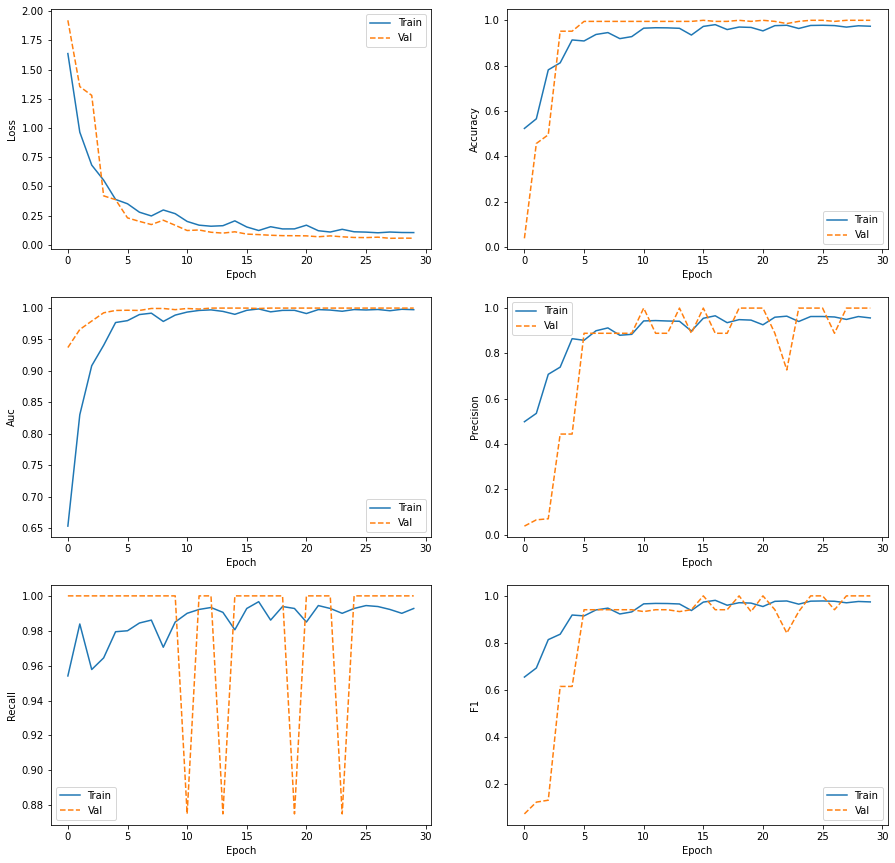

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 7


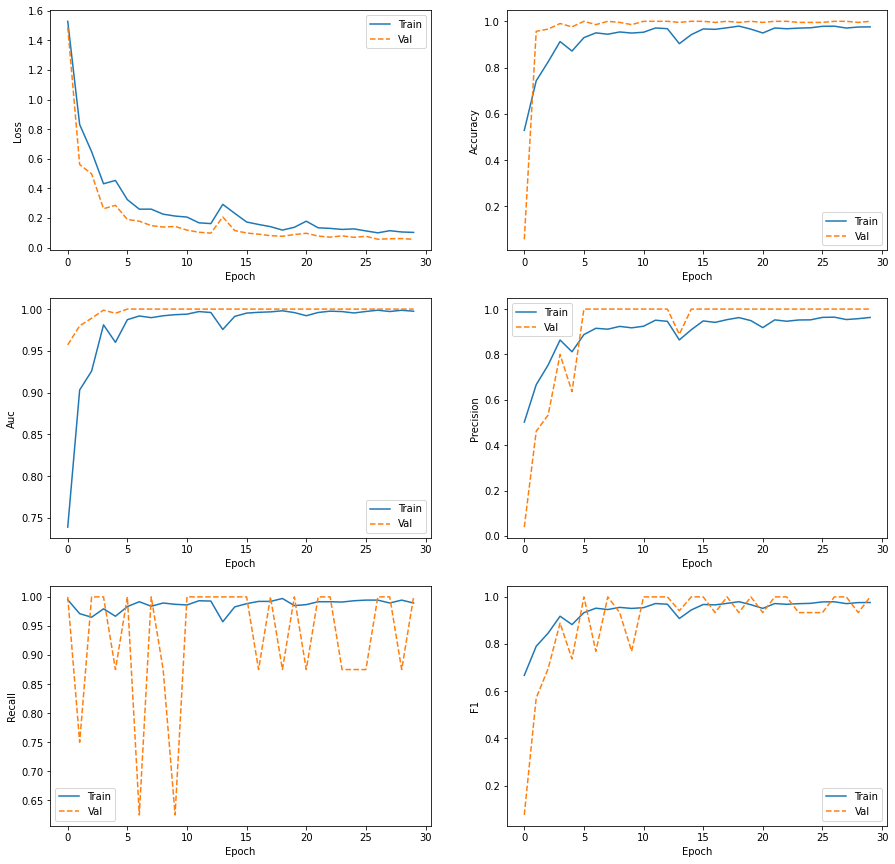

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 8


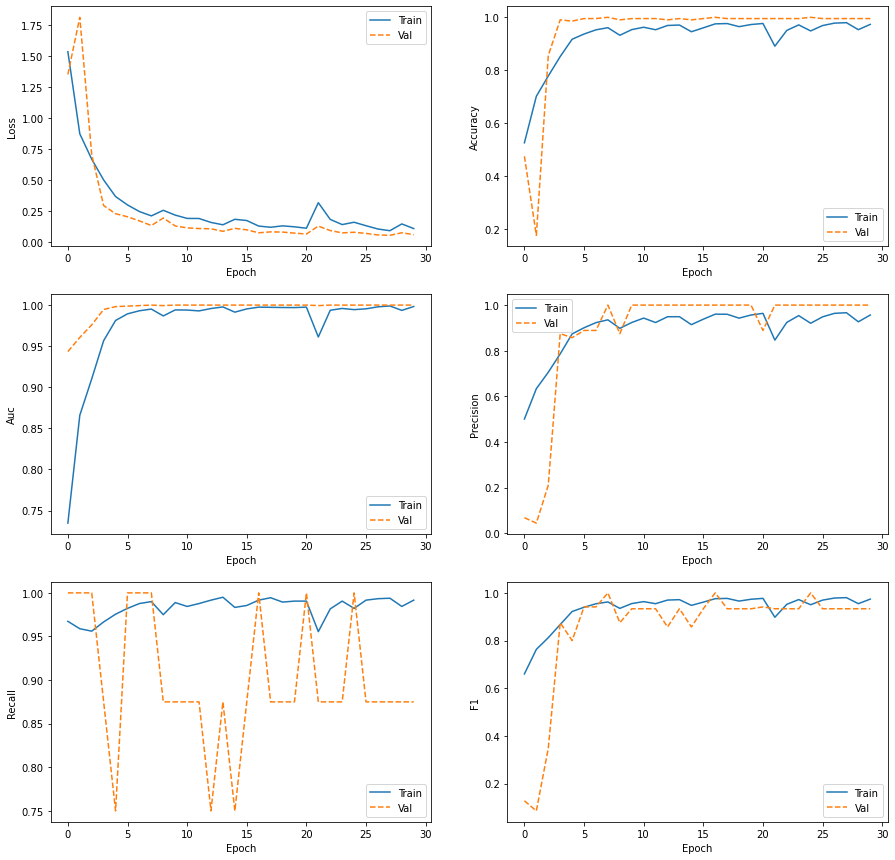

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 9


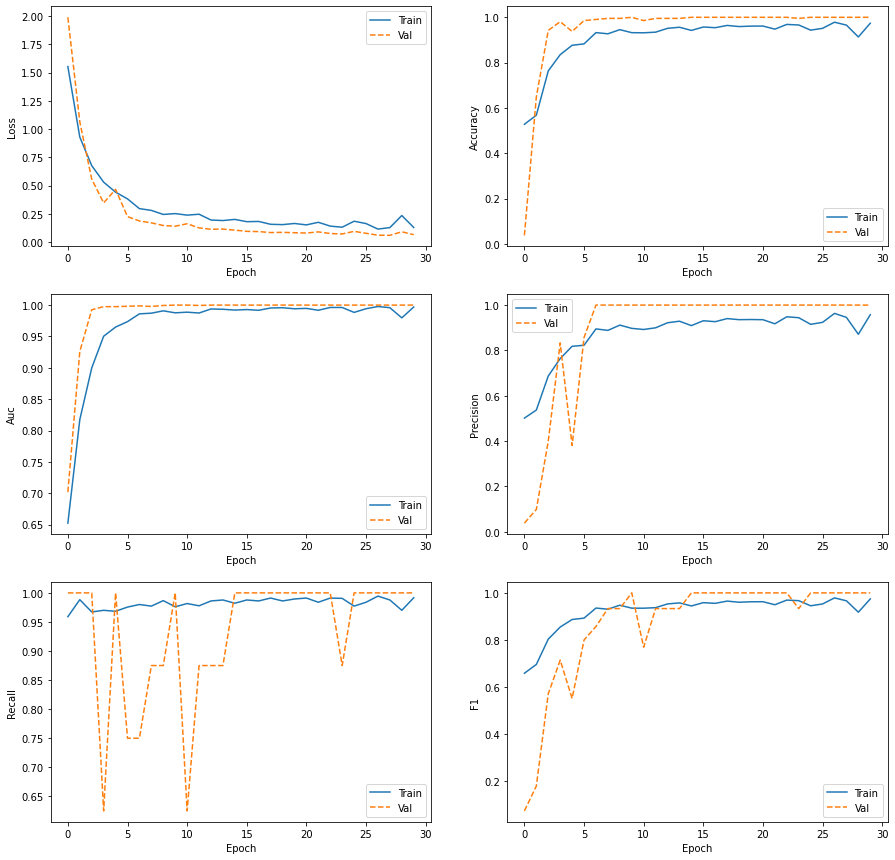

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[1995    5]
 [   5   79]]
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00      2000
       Covid       0.94      0.94      0.94        84

    accuracy                           1.00      2084
   macro avg       0.97      0.97      0.97      2084
weighted avg       1.00      1.00      1.00      2084

['0:26:46.324344', '0:24:59.578698', '0:24:44.888001', '0:24:52.074083', '0:25:47.502279', '0:26:46.466666', '0:25:52.164503', '0:27:15.614188', '0:25:57.727851', '0:23:56.418093']


In [ ]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = sorted(best)[len(best)//2]+1
print("VALIDATION EPOCH: "+str(val_epoch))

val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

#print classification reports and plot histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

In [ ]:
# Evaluation made at epoch 16 (were all folds seem to be stable)
val_epoch = 16
val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)


print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.

Whole K-Fold Evaluation
Confusion Matrix
[[1999    1]
 [   3   81]]
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00      2000
       Covid       0.99      0.96      0.98        84

    accuracy                           1.00      2084
   macro avg       0.99      0.98      0.99      2084
weighted avg       1.00      1.00    

# Test set evaluation

In [ ]:
train_data = {'filename':X_train_paths, 
    'class': [str(i) for i in y_train_labels]}
train_df = pd.DataFrame(train_data)

test_data = {'filename':X_test_paths, 
    'class': [str(i) for i in y_test_labels]}
test_df = pd.DataFrame(test_data)

In [ ]:
shape = (150,150)
train_batch = 150

train_data = {'filename':X_train_paths, 
    'class': [str(i) for i in y_train_labels]}
train_df = pd.DataFrame(train_data)

test_data = {'filename':X_test_paths, 
    'class': [str(i) for i in y_test_labels]}
test_df = pd.DataFrame(test_data)

oversampled_train_df = oversampling(train_df)


train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 20,
                              width_shift_range=0.1,
                              height_shift_range = 0.1,
                              zoom_range=[0.8, 1.3],
                              brightness_range=[0.8,1.2],
                              horizontal_flip=True,
                              fill_mode = "constant")

train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                    directory = base_path,
                                                    target_size= shape,
                                                    batch_size = train_batch,
                                                    color_mode = "grayscale", 
                                                    class_mode = "binary")

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_df, 
                                                                          directory = base_path,
                                                                          target_size = shape,
                                                                          color_mode = "grayscale", 
                                                                          class_mode = "binary",
                                                                          shuffle = False)


Found 4000 validated image filenames belonging to 2 classes.
Found 3100 validated image filenames belonging to 2 classes.


In [ ]:
epochs = 16
class_weight = {0: 0.5, 1: 2}
fp = "/content/drive/MyDrive/DL Project/Covid/callbacks/test/"

cb = ModelCheckpoint(filepath = fp+"weights{epoch:01d}.hdf5", verbose=0, save_best_only=False, save_weights_only=True)

model = build_model()
add_cnl2(model,neurons = [32, 64, 128], drop = 0.4)
add_dense(model, neurons = 128, n = 2, reg = reg.l2(0.005) )

history = model.fit(
        train_generator,
        steps_per_epoch=27,
        epochs=epochs,
        workers=8, class_weight=class_weight, verbose = 2, callbacks = [cb])

Epoch 1/16
27/27 - 104s - loss: 1.4895 - accuracy: 0.5010 - precision: 0.5005 - recall: 0.9895 - auc: 0.6800
Epoch 2/16
27/27 - 47s - loss: 0.8356 - accuracy: 0.6743 - precision: 0.6083 - recall: 0.9785 - auc: 0.8646
Epoch 3/16
27/27 - 46s - loss: 0.6017 - accuracy: 0.8230 - precision: 0.7563 - recall: 0.9530 - auc: 0.9363
Epoch 4/16
27/27 - 47s - loss: 0.4206 - accuracy: 0.8965 - precision: 0.8442 - recall: 0.9725 - auc: 0.9761
Epoch 5/16
27/27 - 45s - loss: 0.3225 - accuracy: 0.9352 - precision: 0.9010 - recall: 0.9780 - auc: 0.9886
Epoch 6/16
27/27 - 45s - loss: 0.2570 - accuracy: 0.9467 - precision: 0.9154 - recall: 0.9845 - auc: 0.9926
Epoch 7/16
27/27 - 46s - loss: 0.2189 - accuracy: 0.9592 - precision: 0.9343 - recall: 0.9880 - auc: 0.9944
Epoch 8/16
27/27 - 46s - loss: 0.3825 - accuracy: 0.8808 - precision: 0.8292 - recall: 0.9590 - auc: 0.9569
Epoch 9/16
27/27 - 46s - loss: 0.2646 - accuracy: 0.9323 - precision: 0.8957 - recall: 0.9785 - auc: 0.9901
Epoch 10/16
27/27 - 46s - l

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)
Y_pred = model.predict(test_generator, nb_samples) 
Y_pred = (Y_pred>0.5)

In [ ]:
test_y_true_list = []
test_y_predictions_list = []
test_y_true_list.extend(test_generator.classes)
test_y_predictions_list.extend(Y_pred)
target_names = ['No Covid', 'Covid']
print("Test evaluation:")
print('Confusion Matrix')
print(confusion_matrix(test_y_true_list, test_y_predictions_list))
report = classification_report(test_generator.classes, Y_pred, target_names=target_names)
print('Classification Report')
print(report)

Test evaluation:
Confusion Matrix
[[2995    5]
 [   3   97]]
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00      3000
       Covid       0.95      0.97      0.96       100

    accuracy                           1.00      3100
   macro avg       0.97      0.98      0.98      3100
weighted avg       1.00      1.00      1.00      3100



In [ ]:
fp = "/content/drive/MyDrive/DL Project/Covid/callbacks/test/"
model = build_model()
add_cnl2(model,neurons = [32, 64, 128], drop = 0.4)
add_dense(model, neurons = 128, n = 2, reg = reg.l2(0.005) )

model.load_weights(filepath = fp + "weights"+str(16)+".hdf5")



# Load Histories

History 0


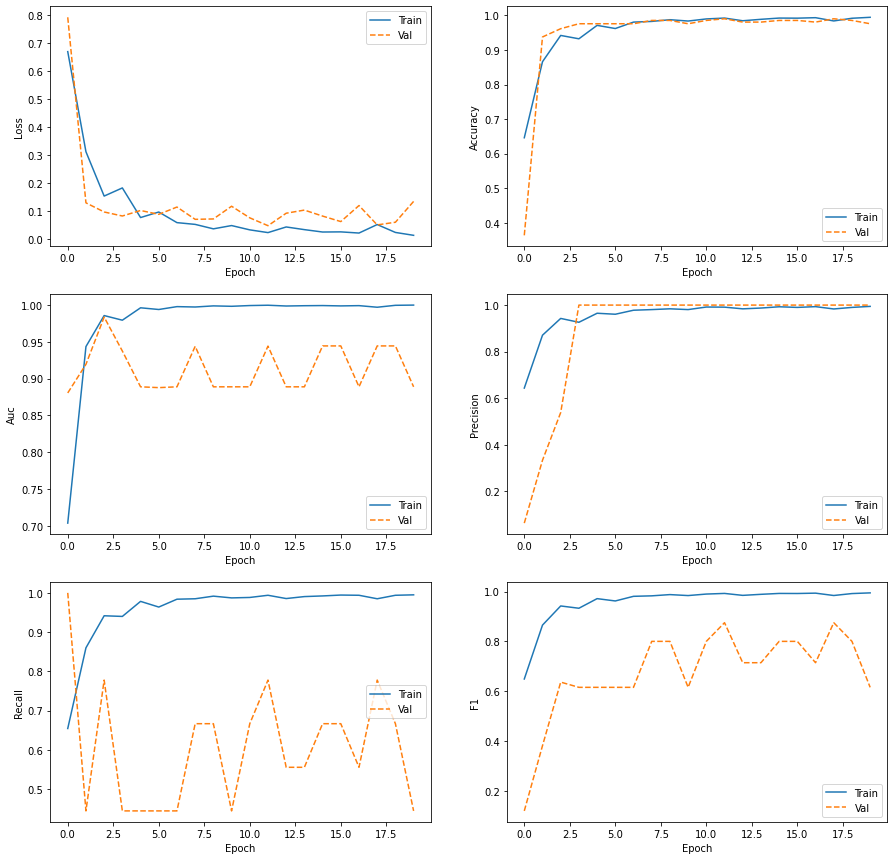

History 1


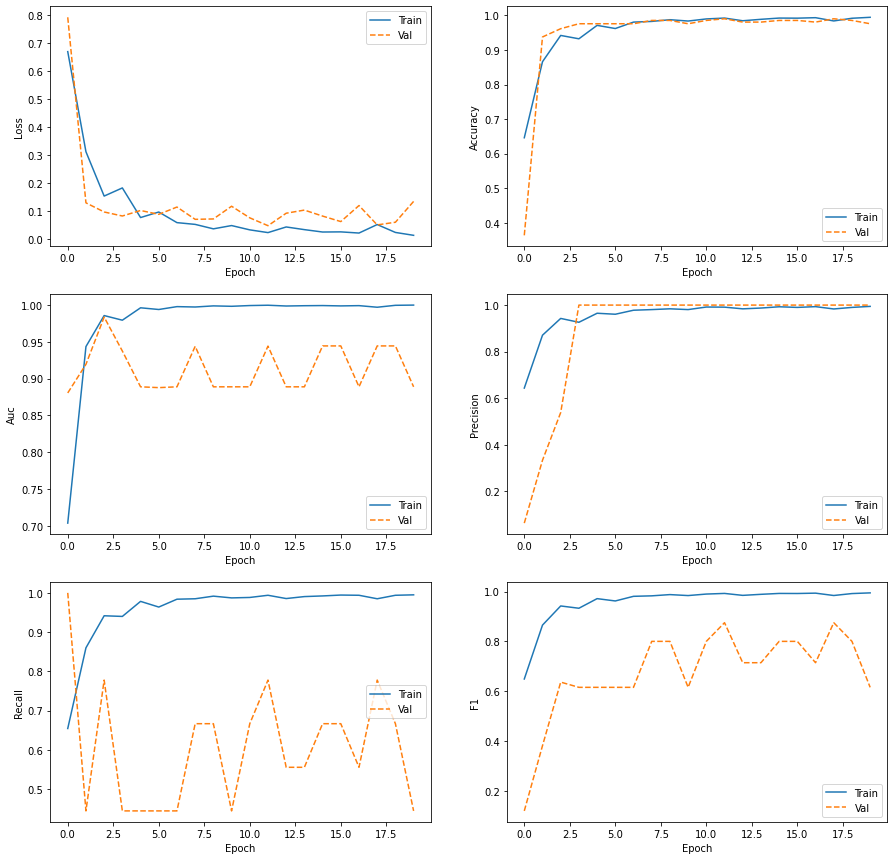

History 2


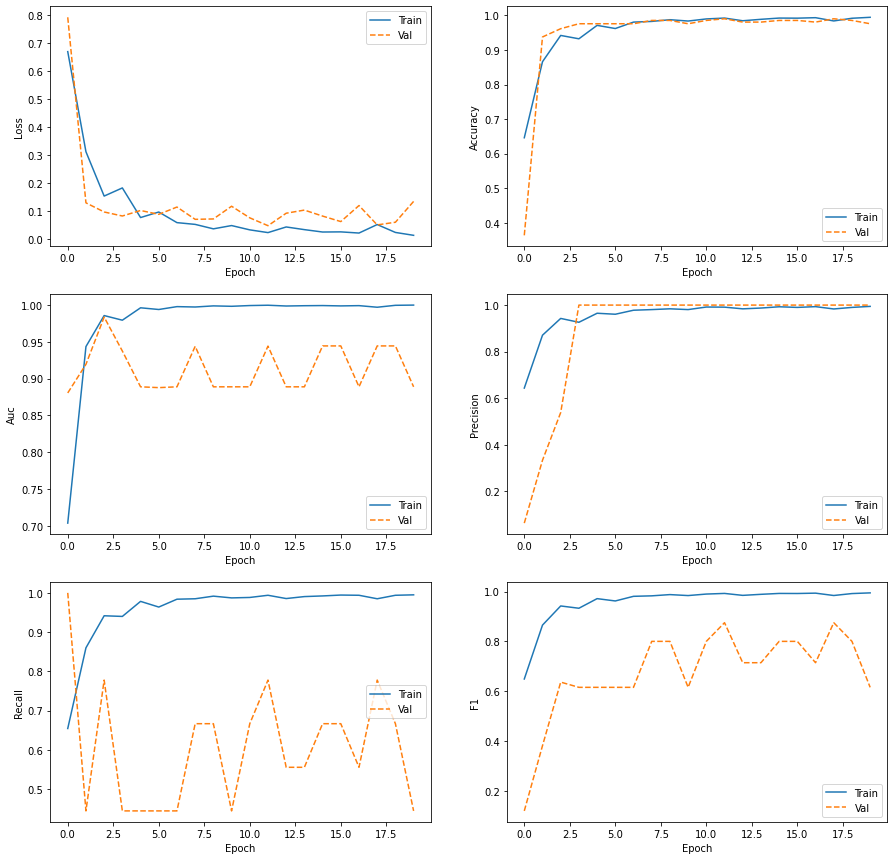

History 3


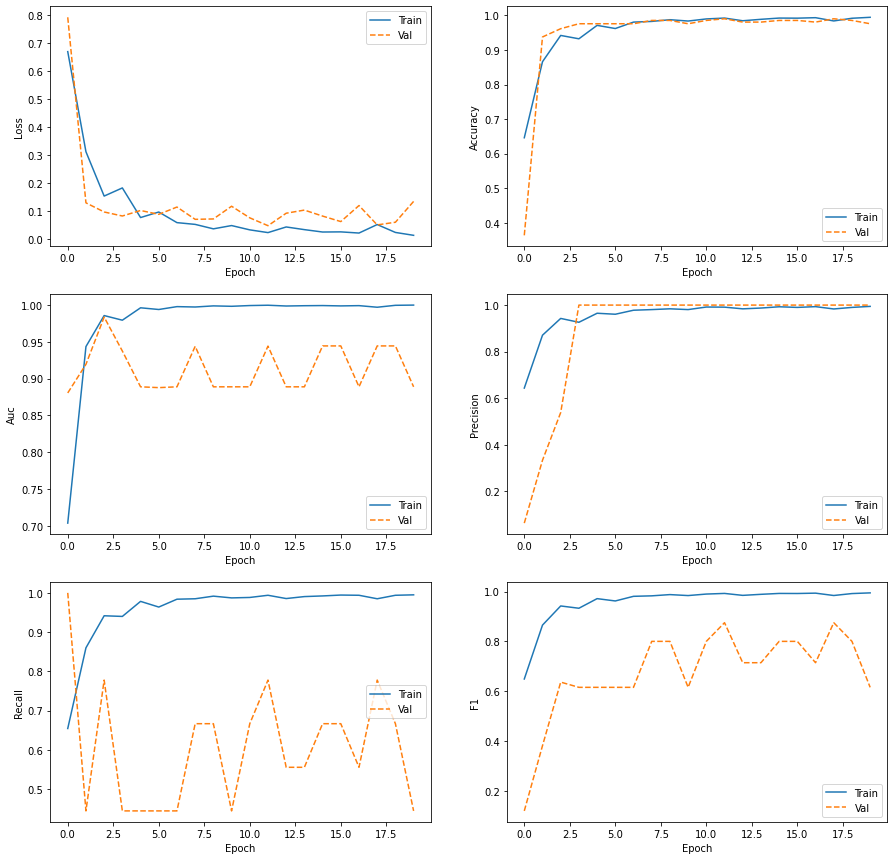

History 4


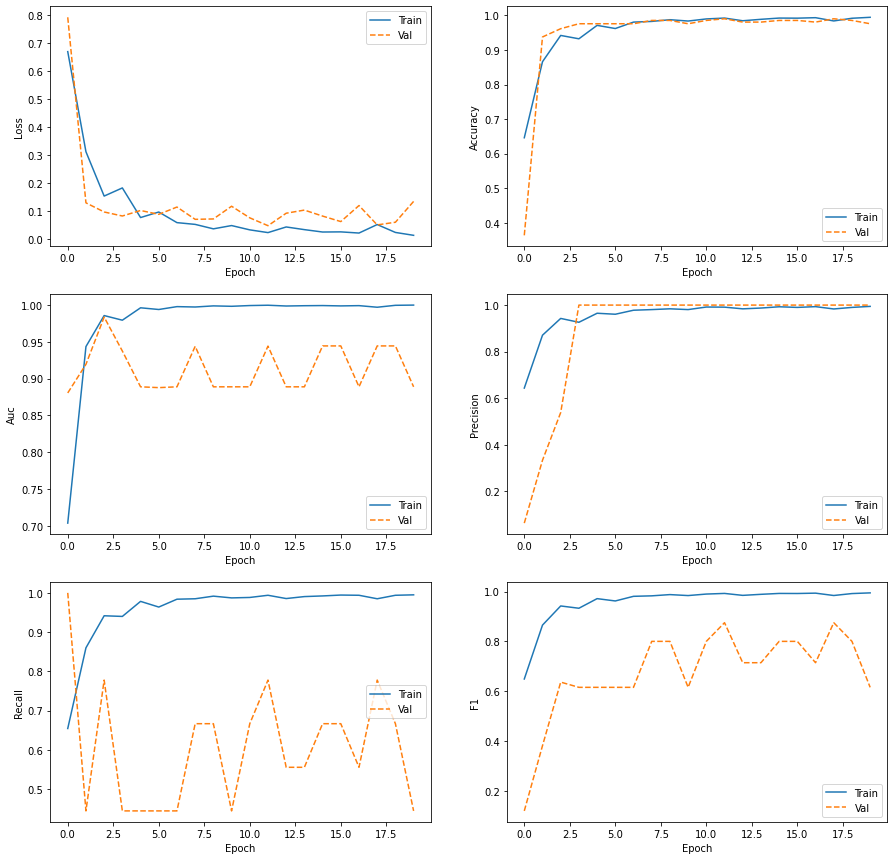

In [ ]:
#To load the histories of a specific model already tested
model_number = 1
number_of_its = 5
for i in range(number_of_its):
  history = json.load(open("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'r'))
  print("History " + str(i))
  plot_metrics(history)

# Error Analysis

In [ ]:
#Find and plot the images that are misclassified
errors = np.where(np.array(test_y_predictions_list).flatten() != test_y_true_list)[0]
errors_path = np.array(X_test_paths)[errors]

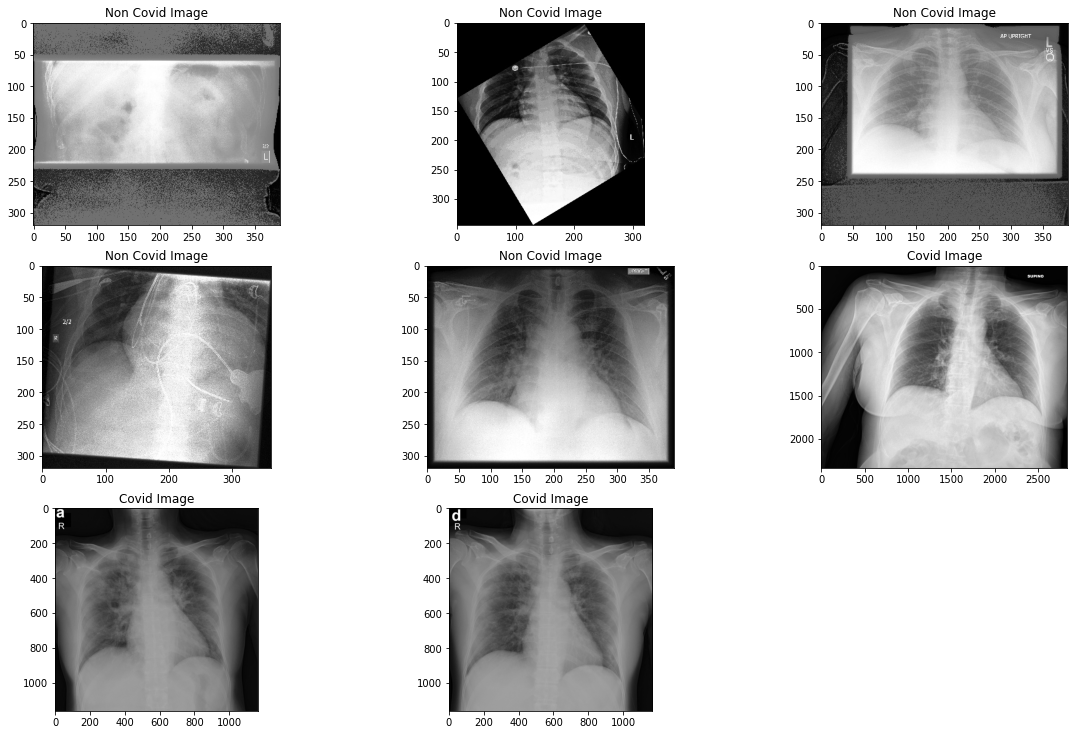

In [ ]:
fig = plt.figure(figsize=(20,35))
for i in range(len(errors)):
    img_path = base_path + errors_path[i]
    img1 = mpimg.imread(img_path)
    if errors[i] <= 3000:
      plt.subplot(len(errors) ,3,i+1).set_title("Non Covid Image")
    else:
      plt.subplot(len(errors) ,3,i+1).set_title("Covid Image")
    plt.imshow(img1, cmap = "gray")

fig.savefig("ErrorAnalysis.png")
plt.show()   